# Sentiment-based Product recommendation System

In [1]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import re, string
import swifter, spacy
import os, random
import pickle

import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE

import xgboost as xgb
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import pairwise_distances

from collections import Counter

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set max column width for dataframe
pd.set_option('display.width', 100)
# pd.set_option('display.max_colwidth', 5000)

In [3]:
# Print python, jupyter and all the imported library versions
import sys
import jupyter_core
import matplotlib
import wordcloud
import sklearn
import imblearn

print("python : {0}".format(sys.version))
print("jupyter : {0}".format(jupyter_core.__version__))
print("numpy : {0}".format(np.__version__))
print("pandas : {0}".format(pd.__version__))
print("matplotlib : {0}".format(matplotlib.__version__))
print("seaborn : {0}".format(sns.__version__))
print("wordcloud : {0}".format(wordcloud.__version__))
print("nltk : {0}".format(nltk.__version__))
print("imblearn : {0}".format(imblearn.__version__))
print("sklearn : {0}".format(sklearn.__version__))
print("xgb : {0}".format(xgb.__version__))
print("swifter : {0}".format(swifter.__version__))
print("pickle : {0}".format(pickle.format_version))
print("spacy : {0}".format(swifter.__version__))

python : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
jupyter : 5.7.2
numpy : 1.26.4
pandas : 2.2.2
matplotlib : 3.9.2
seaborn : 0.13.2
wordcloud : 1.9.4
nltk : 3.9.1
imblearn : 0.12.3
sklearn : 1.5.1
xgb : 2.0.0
swifter : 1.4.0
pickle : 4.0
spacy : 1.4.0


In [4]:
# Download wordnet and punkt libraries on nltk
nltk.download('wordnet')
nltk.download('punkt')

# Load the english core web small
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rohitaggarwal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rohitaggarwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Create the results directory for output
results_path = "results"
outputs_path = "outputs"
os.makedirs(results_path, exist_ok=True)
os.makedirs(outputs_path, exist_ok=True)

## Data Understanding

In [6]:
# Prepare path to the csv file and load the data into a pandas df
file_path = "datasets/sample30.csv"
full_df = pd.read_csv(file_path)

In [7]:
# Create a method to print the shape of data frame
def print_shape(df):
    print("Shape = {}".format(df.shape))

In [8]:
# Create a method to print the shape of data frame along with first 5 rows
def print_shape_and_5rows(df):
    print("Shape = {}".format(df.shape))
    return df.head(5)

In [9]:
# Create a method to print the shape of data frame along with column names
def print_shape_and_columns(df):
    print("Shape = {}".format(df.shape))
    print("Columns = {}".format(df.columns))

In [10]:
# Inspect the dataframe to understand the given data
print_shape_and_5rows(full_df)

Shape = (30000, 15)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [11]:
# Print the information about the data frame
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

## Data Cleaning

In [12]:
# Assign new column names
full_df = full_df.rename(columns={
    "reviews_date": "date", "reviews_didPurchase": "didPurchase", "reviews_doRecommend": "doRecommend", "reviews_rating": "rating",
    "reviews_text": "review", "reviews_title": "title", "reviews_userCity": "userCity", "reviews_userProvince": "province",
    "reviews_username": "username", "user_sentiment": "sentiment"
})
print_shape_and_columns(full_df)

Shape = (30000, 15)
Columns = Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'date', 'didPurchase', 'doRecommend',
       'rating', 'review', 'title', 'userCity', 'province', 'username', 'sentiment'],
      dtype='object')


In [13]:
# Remove all rows where username column is nan
full_df = full_df.dropna(subset=["username"])
print_shape(full_df)

Shape = (29937, 15)


In [14]:
# Fill doRecommend as True if rating is greater than equal to 3, otherwise False
positive_rating = (full_df["rating"] >= 3) & (full_df["doRecommend"].isna())
full_df.loc[positive_rating, "doRecommend"] = True

negative_rating = (full_df["rating"] < 3) & (full_df["doRecommend"].isna())
full_df.loc[negative_rating, "doRecommend"] = False

print_shape(full_df)

Shape = (29937, 15)


In [15]:
# Fill user_sentiment as Positive if rating is greater than 3 and doRecommend is True, otherwise False
positive_sentiment = (full_df["rating"] > 3) & (full_df["doRecommend"] == True)
full_df.loc[positive_sentiment, "sentiment"] = "Positive"

negative_sentiment = (full_df["rating"] < 3) | (full_df["doRecommend"] == False)
full_df.loc[negative_sentiment, "sentiment"] = "Negative"

print_shape(full_df)

Shape = (29937, 15)


In [16]:
# Check columns where more than 75% of data is empty
full_df.columns[full_df.isna().mean() > 0.75]

Index(['userCity', 'province'], dtype='object')

In [17]:
# Drop all columns where the percentage of empty data is more than 75%
full_df = full_df.drop(columns=full_df.columns[full_df.isna().mean() > 0.75])
print_shape(full_df)

Shape = (29937, 13)


In [18]:
# Drop all rows where the review title is empty
full_df = full_df[~full_df['title'].isna()]
print_shape(full_df)

Shape = (29748, 13)


In [19]:
# Drop all rows where the review date is empty
full_df = full_df[~full_df['date'].isna()]
print_shape(full_df)

Shape = (29708, 13)


In [20]:
# Check unique products where manufacturer is empty
full_df[full_df['manufacturer'].isna()]['name'].unique()

array(['Alex Cross (dvdvideo)'], dtype=object)

In [21]:
# There is only one product for which manufacturer is not there, so delete all rows with the product
full_df = full_df[full_df["name"] != "Alex Cross (dvdvideo)"]
print_shape(full_df)

Shape = (29567, 13)


In [22]:
# If the Purchase is set to NaN, set it to false
purchase_nan = full_df["didPurchase"].isna()
full_df.loc[purchase_nan, "didPurchase"] = False

In [23]:
print_shape_and_5rows(full_df)

Shape = (29567, 13)


,id,brand,categories,manufacturer,name,date,didPurchase,doRecommend,rating,review,title,username,sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,False,True,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,True,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,True,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


## Text Preprocessing

In [24]:
# Method to clean the text and remove all the unnecessary elements.
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove text inside square brackets, braces and curly brackets
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'\{.*?\}', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove words containing numbers
    text = ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))

    #Remove unnecessary white spaces
    text = re.sub(r' +', ' ',text)
    
    return text

full_df["review"] = full_df["review"].apply(clean_text)
print_shape(full_df)

Shape = (29567, 13)


In [25]:
# Method to Lemmatize the texts
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    # Tokenize text into words
    words = word_tokenize(text)
    
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into a sentence
    return " ".join(lemmatized_words)

full_df["review_lemmatized"] = full_df["review"].apply(lemmatize_text)
print_shape_and_columns(full_df)

Shape = (29567, 14)
Columns = Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'date', 'didPurchase', 'doRecommend',
       'rating', 'review', 'title', 'username', 'sentiment', 'review_lemmatized'],
      dtype='object')


In [26]:
# Create a new dataframe ('full_df_clean') that will have only the reviews, the lemmatized reviews and sentiment
full_df_clean = full_df[["review", "review_lemmatized", "sentiment"]]
full_df_clean = full_df_clean.reset_index(drop=True)
print_shape_and_5rows(full_df_clean)

Shape = (29567, 3)


,review,review_lemmatized,sentiment
0,i love this album its very good more to the hi...,i love this album it very good more to the hip...,Positive
1,good flavor this review was collected as part ...,good flavor this review wa collected a part of...,Positive
2,good flavor,good flavor,Positive
3,i read through the reviews on here before look...,i read through the review on here before looki...,Negative
4,my husband bought this gel for us the gel caus...,my husband bought this gel for u the gel cause...,Negative


In [27]:
# Define a method to extract the POS tags
def pos_tag(text):
    # Find POS tag of the sentence, filter out words which have tag 'NN'
    doc = nlp(text)
    nn_words = [token.lemma_ for token in doc if token.tag_ == 'NN']

    # Join words back into a sentence
    return " ".join(nn_words)

full_df_clean["review_pos_removed"] = full_df_clean.swifter.apply(lambda x: pos_tag(x['review_lemmatized']), axis=1)
print_shape_and_columns(full_df_clean)

Pandas Apply:   0%|          | 0/29567 [00:00<?, ?it/s]

Shape = (29567, 4)
Columns = Index(['review', 'review_lemmatized', 'sentiment', 'review_pos_removed'], dtype='object')


In [28]:
# Removing -PRON- from the text corpus
full_df_clean['review_clean'] = full_df_clean['review_pos_removed'].str.replace('-PRON-', '')
print_shape_and_columns(full_df_clean)

Shape = (29567, 5)
Columns = Index(['review', 'review_lemmatized', 'sentiment', 'review_pos_removed', 'review_clean'], dtype='object')


In [29]:
# Print the top 5 rows after text processing
print_shape_and_5rows(full_df_clean)

Shape = (29567, 5)


,review,review_lemmatized,sentiment,review_pos_removed,review_clean
0,i love this album its very good more to the hi...,i love this album it very good more to the hip...,Positive,album hip hop side pop sound hype everyday gym...,album hip hop side pop sound hype everyday gym...
1,good flavor this review was collected as part ...,good flavor this review wa collected a part of...,Positive,flavor review part promotion,flavor review part promotion
2,good flavor,good flavor,Positive,flavor,flavor
3,i read through the reviews on here before look...,i read through the review on here before looki...,Negative,review couple lubricant review starter boyfrie...,review couple lubricant review starter boyfrie...
4,my husband bought this gel for us the gel caus...,my husband bought this gel for u the gel cause...,Negative,husband gel gel irritation skin gel,husband gel gel irritation skin gel


## Exploratory Data Analysis

In [30]:
# Define a method to return a random colormap
colormaplist = list(colormaps)
def get_color_map():
    random_colormap = random.randint(0, len(colormaplist))
    return colormaplist[random_colormap]

# Define a method to return a random color
colorlist = list(matplotlib.colors.CSS4_COLORS)
def get_color():
    random_color = random.randint(0, len(colorlist))
    return colorlist[random_color]

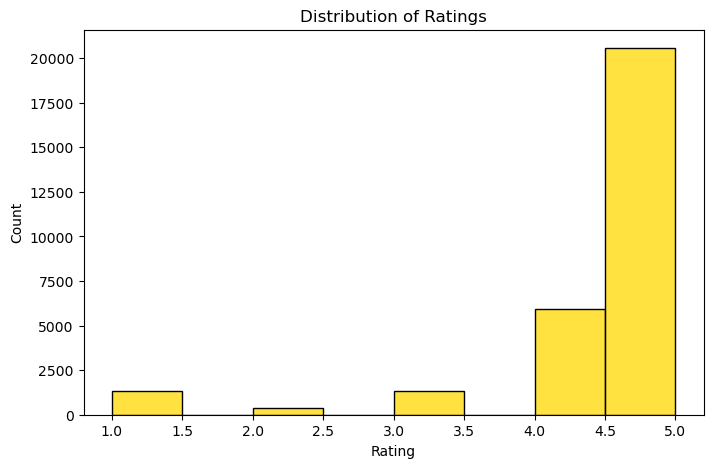

In [31]:
# Visualise the distribution of ratings as a histogram
plt.figure(figsize=(8, 5))
sns.histplot(full_df["rating"], binwidth=0.5, color=get_color())
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

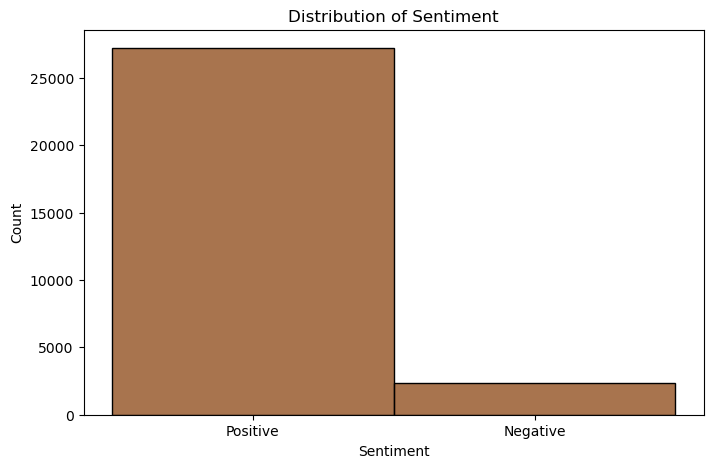

In [32]:
# Visualize the distribution of user sentiment
# Visualise the distribution of ratings as a histogram
plt.figure(figsize=(8, 5))
sns.histplot(full_df["sentiment"], color=get_color())
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiment")
plt.show()

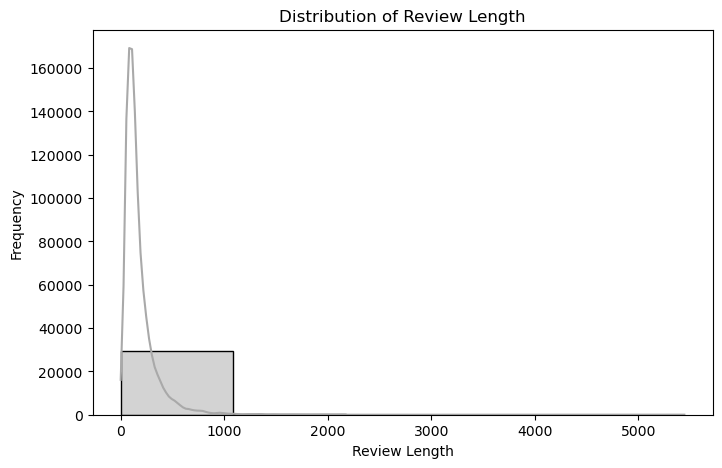

In [33]:
# Visualise the data according to the 'review' character length

# Calculate character length of each text entry
full_df_clean["review_length"] = full_df_clean["review"].apply(len)

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(full_df_clean["review_length"], bins=5, kde=True, color=get_color())
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Length")
plt.show()

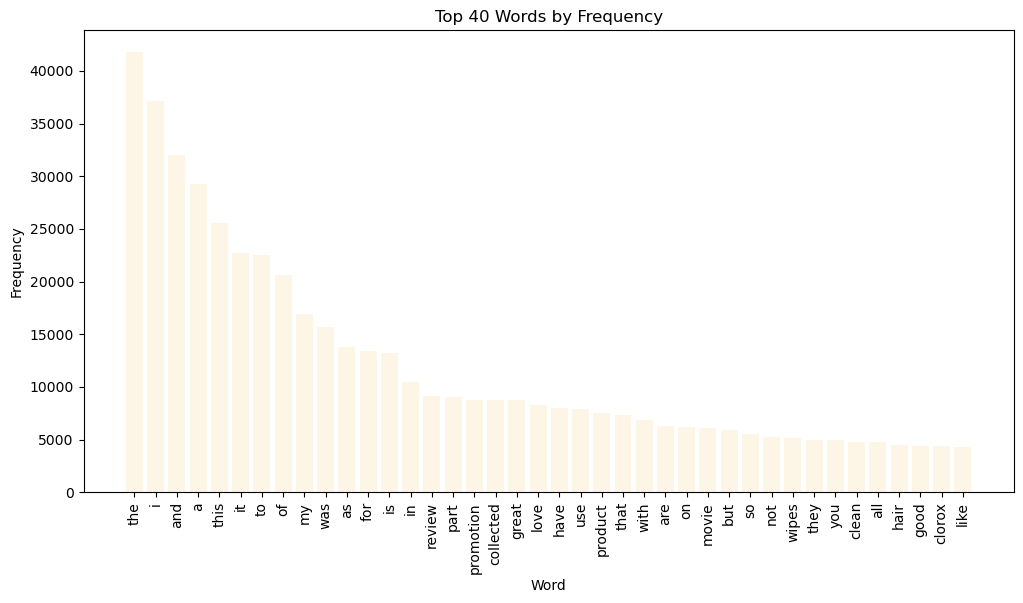

In [34]:
# Find the top 40 words by frequency among all the reviews after processing the text
all_words = [word for review in full_df_clean["review"] for word in review.split()]

# Get the top 40 most common words
word_freq = Counter(all_words).most_common(40)
(words, counts) = zip(*word_freq)

# Plot the top 40 most common words
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color=get_color())
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Top 40 Words by Frequency")
plt.xticks(rotation=90)
plt.show()

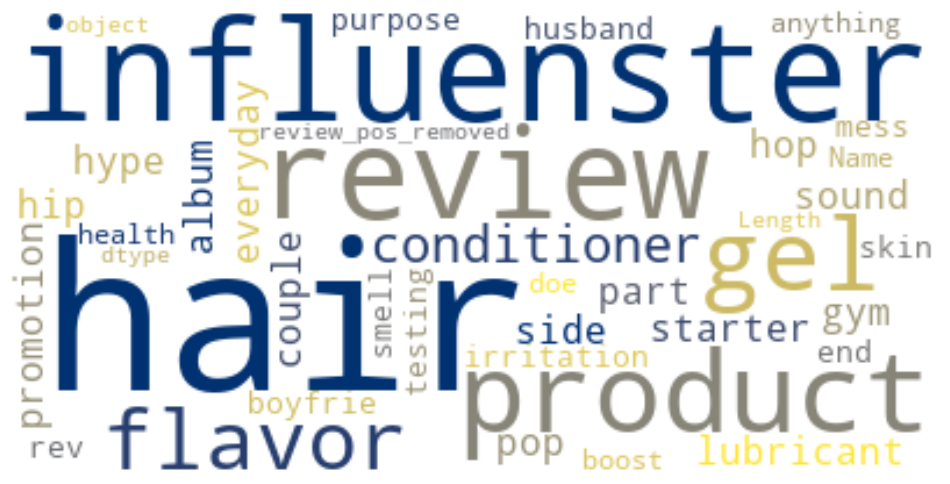

In [35]:
# Print word cloud for top 40 words using review pos removed data

wordcloud = WordCloud(max_words=40, 
                      stopwords=set(stopwords.words('english')), 
                      random_state=42, 
                      colormap="cividis", 
                      background_color="white")
wordcloud.generate(str(full_df_clean['review_pos_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [36]:
# Find the top 30 unigram frequency among the reviews in the cleaned dataframe

# Apply preprocessing to all rows and flatten the list
unigram_words = [word for review in full_df_clean["review_clean"] for word in word_tokenize(review)]

# Get top 30 unigrams by frequency
counter_unigram_words = Counter(unigram_words)
unigram_freq = counter_unigram_words.most_common(30)

# Convert to DataFrame for better readability
unigram_df = pd.DataFrame(unigram_freq, columns=["Unigram", "Frequency"])
print(unigram_df.head(10))

     Unigram  Frequency
0    product       9286
1     review       9210
2       part       9147
3  promotion       8745
4      movie       7310
5       wipe       5579
6       hair       4460
7       time       2734
8       year       2143
9      smell       2104


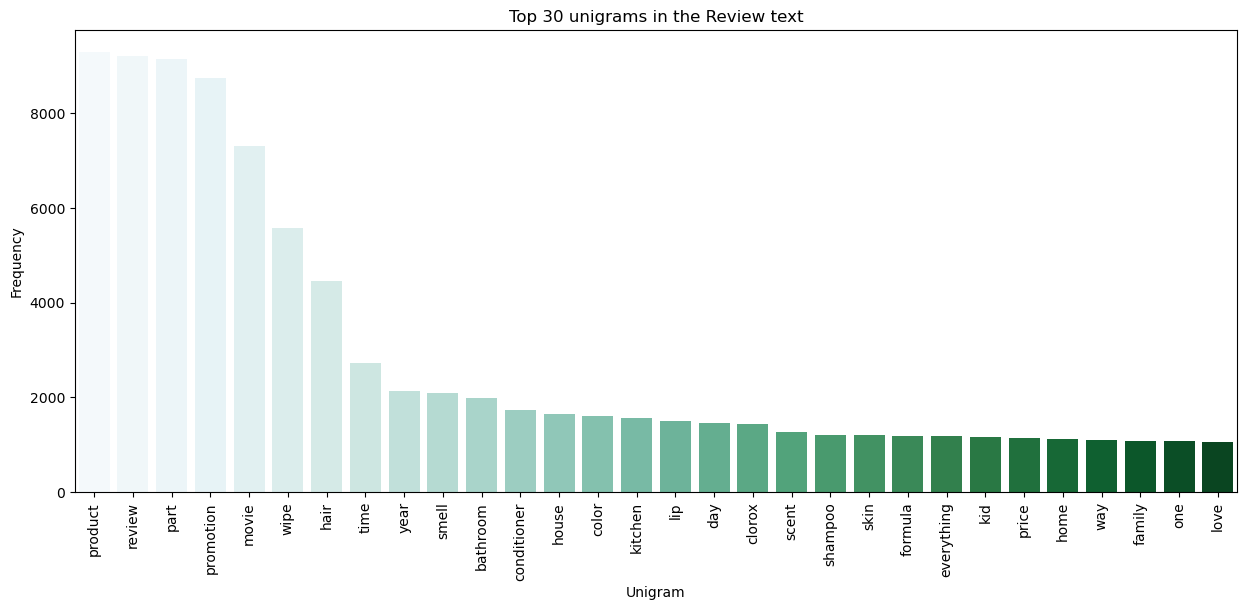

In [37]:
# Plot top 30 unigrams as bar plot

plt.figure(figsize=(15,6))
sns.barplot(x='Unigram', y='Frequency', data=unigram_df, palette=get_color_map())
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Review text")
plt.show()

In [38]:
# Defined a method to return ngrams for a given corpus of text
def get_ngrams(words, n=2):
    return list(nltk.ngrams(words, n))

In [39]:
# Find the top 30 bigram frequency among the reviews in the cleaned dataframe (full_df_clean)
bigram_words = [bigram for review in full_df_clean["review_clean"] for bigram in get_ngrams(word_tokenize(review), 2)]

# Get top 10 bigrams by frequency
counter_bigram_words = Counter(bigram_words)
bigram_freq = counter_bigram_words.most_common(30)

bigram_df = pd.DataFrame(bigram_freq, columns=["Bigram", "Frequency"])
bigram_df["Bigram"] = bigram_df["Bigram"].apply(lambda x: " ".join(x))
print(bigram_df.head(10))

             Bigram  Frequency
0       review part       8740
1    part promotion       8740
2       clorox wipe        835
3    product review        788
4       wipe review        482
5  kitchen bathroom        478
6  conditioner hair        444
7       lip shimmer        415
8         hair hair        399
9       movie movie        377


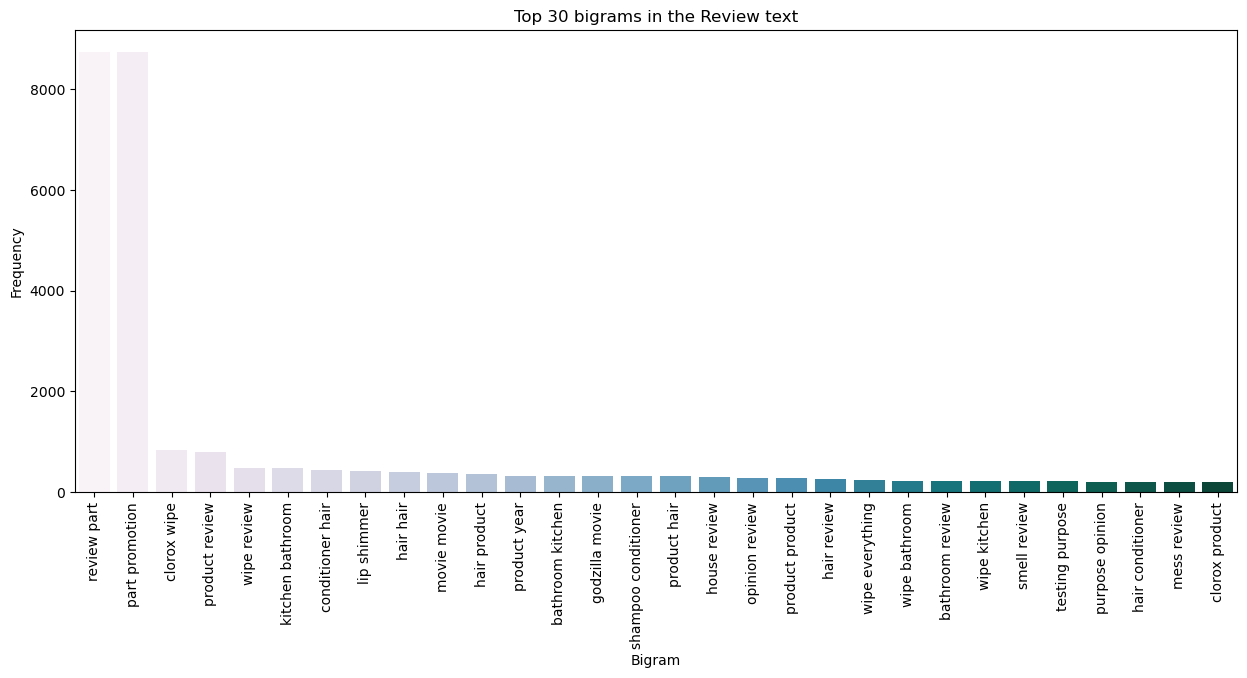

In [40]:
# Plot top 30 bigrams as bar plot
plt.figure(figsize=(15,6))
sns.barplot(x='Bigram', y='Frequency', data=bigram_df, palette=get_color_map())
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Review text")
plt.show()

In [41]:
# Find the top 30 trigram frequency among the reviews in the cleaned dataframe (df_clean)
trigram_words = [trigram for review in full_df_clean["review_clean"] for trigram in get_ngrams(word_tokenize(review), 3)]

# Get top 30 trigrams by frequency
counter_trigram_words = Counter(trigram_words)
trigram_freq = counter_trigram_words.most_common(30)

trigram_df = pd.DataFrame(trigram_freq, columns=["Trigram", "Frequency"])
trigram_df["Trigram"] = trigram_df["Trigram"].apply(lambda x: " ".join(x))
print(trigram_df.head(10))

                 Trigram  Frequency
0  review part promotion       8740
1    product review part        736
2       wipe review part        482
3      house review part        298
4    opinion review part        279
5       hair review part        255
6   bathroom review part        217
7      smell review part        214
8       mess review part        206
9       germ review part        196


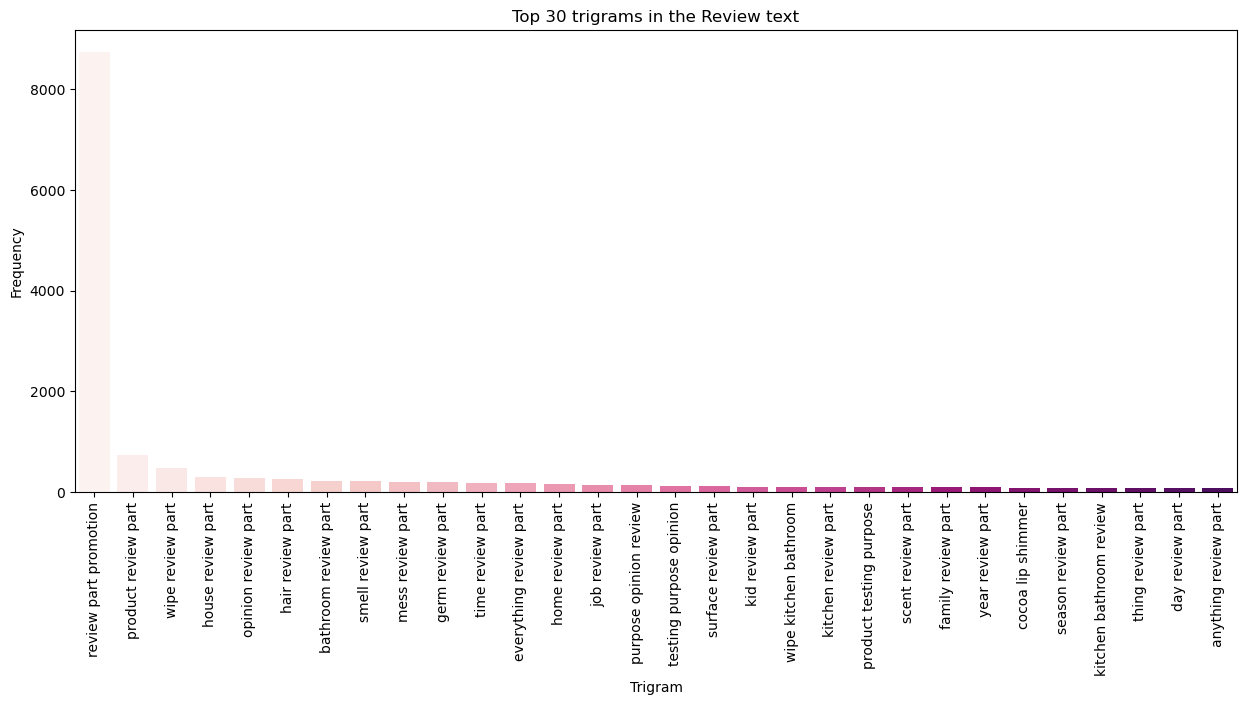

In [42]:
# Plot top 30 trigrams as bar plot

plt.figure(figsize=(15,6))
sns.barplot(x='Trigram', y='Frequency', data=trigram_df, palette=get_color_map())
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Review text")
plt.show()

## Feature Extraction

In [43]:
# Remove the masked text containing personal details of customer
full_df_clean['review_clean'] = full_df_clean['review_clean'].str.replace('xxxx','')
print_shape_and_5rows(full_df_clean)

Shape = (29567, 6)


,review,review_lemmatized,sentiment,review_pos_removed,review_clean,review_length
0,i love this album its very good more to the hi...,i love this album it very good more to the hip...,Positive,album hip hop side pop sound hype everyday gym...,album hip hop side pop sound hype everyday gym...,186
1,good flavor this review was collected as part ...,good flavor this review wa collected a part of...,Positive,flavor review part promotion,flavor review part promotion,60
2,good flavor,good flavor,Positive,flavor,flavor,11
3,i read through the reviews on here before look...,i read through the review on here before looki...,Negative,review couple lubricant review starter boyfrie...,review couple lubricant review starter boyfrie...,670
4,my husband bought this gel for us the gel caus...,my husband bought this gel for u the gel cause...,Negative,husband gel gel irritation skin gel,husband gel gel irritation skin gel,128


In [44]:
# Initialise the TfidfVectorizer, max_df=0.95, min_df=2
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

# Create the Document Term Matrix by transforming the reviews column present in full_df_clean
data_X = tfidf.fit_transform(full_df_clean["review_clean"])

df_X = pd.DataFrame(data_X.toarray(), columns=tfidf.get_feature_names_out())
df_X

,ab,ability,abomination,absence,abundance,academy,accent,access,accessory,accessout,...,yum,zach,zack,zinc,zip,ziplock,zit,zombie,zombieaction,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Keep the columns review & sentiment only in the new dataframe --> training_data
training_data = full_df_clean[["review_lemmatized", "sentiment"]]
print_shape_and_5rows(training_data)

Shape = (29567, 2)


,review_lemmatized,sentiment
0,i love this album it very good more to the hip...,Positive
1,good flavor this review wa collected a part of...,Positive
2,good flavor,Positive
3,i read through the review on here before looki...,Negative
4,my husband bought this gel for u the gel cause...,Negative


In [46]:
sentiment_names = {
    'Negative': 0,
    'Positive': 1 
}
training_data['sentiment'] = training_data['sentiment'].map(sentiment_names)
print_shape_and_5rows(training_data)

Shape = (29567, 2)


,review_lemmatized,sentiment
0,i love this album it very good more to the hip...,1
1,good flavor this review wa collected a part of...,1
2,good flavor,1
3,i read through the review on here before looki...,0
4,my husband bought this gel for u the gel cause...,0


In [47]:
# Get the word vector and transform it to tf-idf
count_vector = CountVectorizer(stop_words="english")
X_count = count_vector.fit_transform(training_data["review_lemmatized"])

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_count)

# Split the file tfidf training data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, training_data["sentiment"], test_size=0.2, random_state=42)

In [48]:
# Dump count vectorizer and tfidf transformer into the outputs directory
with open(outputs_path + "/count_vector.pkl", 'wb') as files:
    pickle.dump(count_vector, files)

with open(outputs_path + "/tfidf_transformer.pkl", 'wb') as files:
    pickle.dump(tfidf_transformer, files)

In [49]:
# Resample the data to have equal positive and negative samples for model building
count = Counter(y_train)
print('Before sampling :', count)

# Initialize sampler and resample
sampler = SMOTE(random_state=42)
X_train_sm, y_train_sm = sampler.fit_resample(X_train, y_train)

count = Counter(y_train_sm)
print('After sampling :',count)

Before sampling : Counter({1: 21740, 0: 1913})
After sampling : Counter({1: 21740, 0: 21740})


## Sentiment Model Building

In [50]:
# Define a function to print various metrics comparing the actual and prediction
model_metrics = pd.DataFrame(columns = ["model", "confusion_matrix", "accuracy_score", "roc_auc_score", 
                                        "precision_score", "recall_score", "f1_score"])

def print_metrics(model, actual, prediction, model_metrics):
    classification_report = metrics.classification_report(y_true=actual, y_pred=prediction)
    print("Classification Report = \n", classification_report)
    
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    print("Confusion Matrix = \n", confusion_matrix)

    accuracy_score = round(metrics.accuracy_score(actual, prediction), 2)
    print("Accuracy score =", accuracy_score)

    roc_auc_score = round(metrics.roc_auc_score(actual, prediction), 2)
    print("ROC AUC score =", roc_auc_score)

    precision_score = round(metrics.precision_score(actual, prediction, average="weighted"), 2)
    print("Precision score =", precision_score)

    recall_score = round(metrics.recall_score(actual, prediction, average="weighted"), 2)
    print("Recall score =", recall_score)

    f1_score = round(metrics.f1_score(actual, prediction, average="weighted"), 2)
    print("F1 score =", f1_score)

    model_metrics.loc[len(model_metrics)] = (model, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score)
    return model_metrics

### Logistic Regression

In [51]:
# Build logistic regression model
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_sm, y_train_sm)

LogisticRegression()

In [52]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model
y_train_pred = logistic_reg.predict(X_train_sm)
y_train_pred = pd.DataFrame({ 'sentiment': y_train_sm, 'sentiment_predicted': y_train_pred, 'id': y_train_sm.index })
y_train_pred

,sentiment,sentiment_predicted,id
0,1,1,0
1,1,1,1
2,0,1,2
3,1,0,3
4,1,1,4
...,...,...,...
43475,0,0,43475
43476,0,0,43476
43477,0,0,43477
43478,0,0,43478


In [53]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Logistic Regression (Training Data)', 
                              y_train_pred.sentiment, 
                              y_train_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     21740
           1       0.97      0.95      0.96     21740

    accuracy                           0.96     43480
   macro avg       0.96      0.96      0.96     43480
weighted avg       0.96      0.96      0.96     43480

Confusion Matrix = 
 [[21008   732]
 [ 1135 20605]]
Accuracy score = 0.96
ROC AUC score = 0.96
Precision score = 0.96
Recall score = 0.96
F1 score = 0.96


In [54]:
# Prepare dataframe containing actual sentiment and predicted sentiment obtained from the model for testing data
y_test_pred = logistic_reg.predict(X_test)
y_test_pred = pd.DataFrame({ 'sentiment': y_test, 'sentiment_predicted': y_test_pred, 'id': y_test.index })
y_test_pred

,sentiment,sentiment_predicted,id
28267,1,1,28267
15603,1,1,15603
7839,1,1,7839
4850,1,1,4850
4699,1,1,4699
...,...,...,...
28135,1,1,28135
3,0,0,3
17328,1,1,17328
1632,1,0,1632


In [55]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Logistic Regression (Testing Data)', 
                              y_test_pred.sentiment, 
                              y_test_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.49      0.74      0.59       439
           1       0.98      0.94      0.96      5475

    accuracy                           0.92      5914
   macro avg       0.73      0.84      0.77      5914
weighted avg       0.94      0.92      0.93      5914

Confusion Matrix = 
 [[ 326  113]
 [ 341 5134]]
Accuracy score = 0.92
ROC AUC score = 0.84
Precision score = 0.94
Recall score = 0.92
F1 score = 0.93


In [56]:
# Dump the model parameters for logistic regression
with open(results_path + "/logistic_regression.pkl", 'wb') as files:
    pickle.dump(logistic_reg, files)

### Random Forest

In [57]:
# Build decision tree model
random_forest = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
random_forest.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=20, random_state=42)

In [58]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model
y_train_pred = random_forest.predict(X_train_sm)
y_train_pred = pd.DataFrame({ 'sentiment': y_train_sm, 'sentiment_predicted': y_train_pred, 'id': y_train_sm.index })
y_train_pred

,sentiment,sentiment_predicted,id
0,1,1,0
1,1,1,1
2,0,1,2
3,1,1,3
4,1,1,4
...,...,...,...
43475,0,0,43475
43476,0,0,43476
43477,0,0,43477
43478,0,0,43478


In [59]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Random Forest (Training Data)', 
                              y_train_pred.sentiment, 
                              y_train_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.98      0.83      0.90     21740
           1       0.85      0.98      0.91     21740

    accuracy                           0.91     43480
   macro avg       0.92      0.91      0.91     43480
weighted avg       0.92      0.91      0.91     43480

Confusion Matrix = 
 [[18029  3711]
 [  340 21400]]
Accuracy score = 0.91
ROC AUC score = 0.91
Precision score = 0.92
Recall score = 0.91
F1 score = 0.91


In [60]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model for testing data
y_test_pred = random_forest.predict(X_test)
y_test_pred = pd.DataFrame({ 'sentiment': y_test, 'sentiment_predicted': y_test_pred, 'id': y_test.index })
y_test_pred

,sentiment,sentiment_predicted,id
28267,1,1,28267
15603,1,1,15603
7839,1,1,7839
4850,1,1,4850
4699,1,1,4699
...,...,...,...
28135,1,1,28135
3,0,0,3
17328,1,1,17328
1632,1,1,1632


In [61]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Random Forest (Testing Data)', 
                              y_test_pred.sentiment, 
                              y_test_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.51      0.55      0.53       439
           1       0.96      0.96      0.96      5475

    accuracy                           0.93      5914
   macro avg       0.74      0.75      0.74      5914
weighted avg       0.93      0.93      0.93      5914

Confusion Matrix = 
 [[ 241  198]
 [ 234 5241]]
Accuracy score = 0.93
ROC AUC score = 0.75
Precision score = 0.93
Recall score = 0.93
F1 score = 0.93


In [62]:
# Dump the model parameters for random forest
with open(results_path + "/random_forest.pkl", 'wb') as files:
    pickle.dump(random_forest, files)

### XGBoost

In [63]:
# Build XGB regression model
xgb_classifier = xgb.XGBClassifier(n_jobs = -1, objective = 'binary:logistic')
xgb_classifier.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [64]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model
y_train_pred = xgb_classifier.predict(X_train)
y_train_pred = pd.DataFrame({ 'sentiment': y_train, 'sentiment_predicted': y_train_pred, 'id': y_train.index })
y_train_pred

,sentiment,sentiment_predicted,id
7748,1,1,7748
24202,1,1,24202
22719,0,1,22719
24534,1,1,24534
16068,1,1,16068
...,...,...,...
21575,1,1,21575
5390,1,1,5390
860,1,1,860
15795,1,1,15795


In [65]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('XGB Classification (Training Data)', 
                              y_train_pred.sentiment, 
                              y_train_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.80      0.73      0.76      1913
           1       0.98      0.98      0.98     21740

    accuracy                           0.96     23653
   macro avg       0.89      0.86      0.87     23653
weighted avg       0.96      0.96      0.96     23653

Confusion Matrix = 
 [[ 1395   518]
 [  343 21397]]
Accuracy score = 0.96
ROC AUC score = 0.86
Precision score = 0.96
Recall score = 0.96
F1 score = 0.96


In [66]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model for testing data
y_test_pred = xgb_classifier.predict(X_test)
y_test_pred = pd.DataFrame({ 'sentiment': y_test, 'sentiment_predicted': y_test_pred, 'id': y_test.index })
y_test_pred

,sentiment,sentiment_predicted,id
28267,1,1,28267
15603,1,1,15603
7839,1,1,7839
4850,1,1,4850
4699,1,1,4699
...,...,...,...
28135,1,1,28135
3,0,0,3
17328,1,1,17328
1632,1,0,1632


In [67]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('XGB Classification (Testing Data)', 
                              y_test_pred.sentiment, 
                              y_test_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.57      0.56      0.56       439
           1       0.96      0.97      0.97      5475

    accuracy                           0.94      5914
   macro avg       0.77      0.76      0.76      5914
weighted avg       0.94      0.94      0.94      5914

Confusion Matrix = 
 [[ 247  192]
 [ 189 5286]]
Accuracy score = 0.94
ROC AUC score = 0.76
Precision score = 0.94
Recall score = 0.94
F1 score = 0.94


In [68]:
# Dump the model parameters for xgb classifier
with open(results_path + "/xgb_classifier.pkl", 'wb') as files:
    pickle.dump(xgb_classifier, files)

### Naive Bayes

In [69]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [70]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model
y_train_pred = nb_classifier.predict(X_train)
y_train_pred = pd.DataFrame({ 'sentiment': y_train, 'sentiment_predicted': y_train_pred, 'id': y_train.index })
y_train_pred

,sentiment,sentiment_predicted,id
7748,1,1,7748
24202,1,1,24202
22719,0,1,22719
24534,1,1,24534
16068,1,1,16068
...,...,...,...
21575,1,1,21575
5390,1,1,5390
860,1,1,860
15795,1,1,15795


In [71]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Naive Bayes (Training Data)', 
                              y_train_pred.sentiment, 
                              y_train_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.98      0.23      0.37      1913
           1       0.94      1.00      0.97     21740

    accuracy                           0.94     23653
   macro avg       0.96      0.62      0.67     23653
weighted avg       0.94      0.94      0.92     23653

Confusion Matrix = 
 [[  442  1471]
 [    7 21733]]
Accuracy score = 0.94
ROC AUC score = 0.62
Precision score = 0.94
Recall score = 0.94
F1 score = 0.92


In [72]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model for testing data
y_test_pred = nb_classifier.predict(X_test)
y_test_pred = pd.DataFrame({ 'sentiment': y_test, 'sentiment_predicted': y_test_pred, 'id': y_test.index })
y_test_pred

,sentiment,sentiment_predicted,id
28267,1,1,28267
15603,1,1,15603
7839,1,1,7839
4850,1,1,4850
4699,1,1,4699
...,...,...,...
28135,1,1,28135
3,0,1,3
17328,1,1,17328
1632,1,1,1632


In [73]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Naive Bayes (Testing Data)', 
                              y_test_pred.sentiment, 
                              y_test_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.96      0.21      0.35       439
           1       0.94      1.00      0.97      5475

    accuracy                           0.94      5914
   macro avg       0.95      0.61      0.66      5914
weighted avg       0.94      0.94      0.92      5914

Confusion Matrix = 
 [[  94  345]
 [   4 5471]]
Accuracy score = 0.94
ROC AUC score = 0.61
Precision score = 0.94
Recall score = 0.94
F1 score = 0.92


In [74]:
# Dump the model parameters for naive bayes
with open(results_path + "/naive_bayes.pkl", 'wb') as files:
    pickle.dump(nb_classifier, files)

### Random Forest - Parameter Tuned

In [75]:
n_estimators = [50, 100, 200, 400]
max_depth = [5, 10, 20, 25]
min_samples_leaf = [5, 7, 10]
criterion = ['gini', 'entropy']

params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'criterion':criterion
}

random_forest_grid = GridSearchCV(estimator = random_forest,
                       param_grid = params,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)
random_forest_grid.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=RandomForestClassifier(max_depth=20, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 25],
                         'min_samples_leaf': [5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='roc_auc', verbose=1)

In [76]:
# Find the best random forest parameter and prints its score and configuration
random_forest_final = random_forest_grid.best_estimator_
print("Best score =", random_forest_grid.best_score_)
random_forest_final

Best score = 0.9660321995583837


RandomForestClassifier(max_depth=25, min_samples_leaf=5, n_estimators=400,
                       random_state=42)

In [77]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model
y_train_pred = random_forest_final.predict(X_train_sm)
y_train_pred = pd.DataFrame({ 'sentiment': y_train_sm, 'sentiment_predicted': y_train_pred, 'id': y_train_sm.index })
y_train_pred

,sentiment,sentiment_predicted,id
0,1,1,0
1,1,1,1
2,0,1,2
3,1,1,3
4,1,1,4
...,...,...,...
43475,0,0,43475
43476,0,0,43476
43477,0,0,43477
43478,0,0,43478


In [78]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Random Forest - Tuned (Training Data)', 
                              y_train_pred.sentiment, 
                              y_train_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.96      0.83      0.89     21740
           1       0.85      0.96      0.90     21740

    accuracy                           0.90     43480
   macro avg       0.90      0.90      0.90     43480
weighted avg       0.90      0.90      0.90     43480

Confusion Matrix = 
 [[18137  3603]
 [  848 20892]]
Accuracy score = 0.9
ROC AUC score = 0.9
Precision score = 0.9
Recall score = 0.9
F1 score = 0.9


In [79]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model for testing data
y_test_pred = random_forest_final.predict(X_test)
y_test_pred = pd.DataFrame({ 'sentiment': y_test, 'sentiment_predicted': y_test_pred, 'id': y_test.index })
y_test_pred

,sentiment,sentiment_predicted,id
28267,1,1,28267
15603,1,1,15603
7839,1,1,7839
4850,1,0,4850
4699,1,1,4699
...,...,...,...
28135,1,1,28135
3,0,0,3
17328,1,1,17328
1632,1,1,1632


In [80]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Random Forest - Tuned (Testing Data)', 
                              y_test_pred.sentiment, 
                              y_test_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.47      0.55      0.51       439
           1       0.96      0.95      0.96      5475

    accuracy                           0.92      5914
   macro avg       0.72      0.75      0.73      5914
weighted avg       0.93      0.92      0.92      5914

Confusion Matrix = 
 [[ 241  198]
 [ 267 5208]]
Accuracy score = 0.92
ROC AUC score = 0.75
Precision score = 0.93
Recall score = 0.92
F1 score = 0.92


In [81]:
# Dump the model parameters for tuned random forest
with open(results_path + "/random_forest_tuned.pkl", 'wb') as files:
    pickle.dump(random_forest_final, files)

### XGBoost - Parameter Tuned

In [82]:
n_estimators = [50, 100, 200, 400]

params = {'n_estimators': n_estimators}

xgb_classifier_grid = GridSearchCV(estimator = xgb_classifier,
                       param_grid = params,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)
xgb_classifier_grid.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1, param_grid={'n_estimators': [50, 100, 200, 400]},
             scoring='roc_auc', verbose=1)

In [83]:
# Find the best XGB parameter and prints its score and configuration
xgb_classifier_final = xgb_classifier_grid.best_estimator_
print("Best score =", xgb_classifier_grid.best_score_)
xgb_classifier_final

Best score = 0.9940660257674331


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [84]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model
y_train_pred = xgb_classifier_final.predict(X_train_sm)
y_train_pred = pd.DataFrame({ 'sentiment': y_train_sm, 'sentiment_predicted': y_train_pred, 'id': y_train_sm.index })
y_train_pred

,sentiment,sentiment_predicted,id
0,1,1,0
1,1,1,1
2,0,1,2
3,1,1,3
4,1,1,4
...,...,...,...
43475,0,0,43475
43476,0,0,43476
43477,0,0,43477
43478,0,0,43478


In [85]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('XGB Classification - Tuned (Training Data)', 
                              y_train_pred.sentiment, 
                              y_train_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     21740
           1       0.99      1.00      0.99     21740

    accuracy                           0.99     43480
   macro avg       0.99      0.99      0.99     43480
weighted avg       0.99      0.99      0.99     43480

Confusion Matrix = 
 [[21463   277]
 [   52 21688]]
Accuracy score = 0.99
ROC AUC score = 0.99
Precision score = 0.99
Recall score = 0.99
F1 score = 0.99


In [86]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model for testing data
y_test_pred = xgb_classifier_final.predict(X_test)
y_test_pred = pd.DataFrame({ 'sentiment': y_test, 'sentiment_predicted': y_test_pred, 'id': y_test.index })
y_test_pred

,sentiment,sentiment_predicted,id
28267,1,1,28267
15603,1,1,15603
7839,1,1,7839
4850,1,1,4850
4699,1,1,4699
...,...,...,...
28135,1,1,28135
3,0,0,3
17328,1,1,17328
1632,1,0,1632


In [87]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('XGB Classification - Tuned (Testing Data)', 
                              y_test_pred.sentiment, 
                              y_test_pred.sentiment_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.65      0.60      0.62       439
           1       0.97      0.97      0.97      5475

    accuracy                           0.95      5914
   macro avg       0.81      0.79      0.80      5914
weighted avg       0.94      0.95      0.95      5914

Confusion Matrix = 
 [[ 262  177]
 [ 140 5335]]
Accuracy score = 0.95
ROC AUC score = 0.79
Precision score = 0.94
Recall score = 0.95
F1 score = 0.95


In [88]:
# Dump the model parameters for logistic regression
with open(results_path + "/xgb_classifier_tuned.pkl", 'wb') as files:
    pickle.dump(xgb_classifier_final, files)

## Sentiment Model Inference

In [89]:
# Print a comparison of all the above models along with the various scores
model_metrics

,model,confusion_matrix,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score
0,Logistic Regression (Training Data),"[[21008, 732], [1135, 20605]]",0.96,0.96,0.96,0.96,0.96
1,Logistic Regression (Testing Data),"[[326, 113], [341, 5134]]",0.92,0.84,0.94,0.92,0.93
2,Random Forest (Training Data),"[[18029, 3711], [340, 21400]]",0.91,0.91,0.92,0.91,0.91
3,Random Forest (Testing Data),"[[241, 198], [234, 5241]]",0.93,0.75,0.93,0.93,0.93
4,XGB Classification (Training Data),"[[1395, 518], [343, 21397]]",0.96,0.86,0.96,0.96,0.96
5,XGB Classification (Testing Data),"[[247, 192], [189, 5286]]",0.94,0.76,0.94,0.94,0.94
6,Naive Bayes (Training Data),"[[442, 1471], [7, 21733]]",0.94,0.62,0.94,0.94,0.92
7,Naive Bayes (Testing Data),"[[94, 345], [4, 5471]]",0.94,0.61,0.94,0.94,0.92
8,Random Forest - Tuned (Training Data),"[[18137, 3603], [848, 20892]]",0.90,0.90,0.90,0.90,0.90
9,Random Forest - Tuned (Testing Data),"[[241, 198], [267, 5208]]",0.92,0.75,0.93,0.92,0.92


#### By checking the ROC-AUC score for various models (Logistic, XGBoost Classifier) etc along with Hyperparameter tuning. XGBoost with hyperparameter tuning will be used as it is having best ROC-AUC score for training-testing data combined

In [90]:
# Use XGBoost classifier as the final selected model
model = xgb_classifier_final
with open(outputs_path + "/model.pkl", 'wb') as files:
    pickle.dump(model, files)

## Recommendation System Building

In [91]:
# Group by dataframe by username and name, and find the mean of ratings provided
recom_df = full_df.groupby(['username', 'name'])['rating'].mean().reset_index()
print_shape_and_5rows(recom_df)

Shape = (27224, 3)


,username,name,rating
0,00dog3,Chex Muddy Buddies Brownie Supreme Snack Mix,4.0
1,00sab00,Mike Dave Need Wedding Dates (dvd + Digital),1.0
2,00sab00,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,3.0
3,01impala,Godzilla 3d Includes Digital Copy Ultraviolet ...,3.0
4,02dakota,Godzilla 3d Includes Digital Copy Ultraviolet ...,5.0


In [92]:
# Split the data into train and test dataset for building
recom_df_train, recom_df_test = train_test_split(recom_df, test_size=0.2, random_state=31)
print_shape_and_5rows(recom_df_test)

Shape = (5445, 3)


,username,name,rating
12860,jweav,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
19761,onthegomom,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
8323,esanta9368,Dark Shadows (includes Digital Copy) (ultravio...,5.0
18583,mt1968,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
20132,pdp76092,Clorox Disinfecting Bathroom Cleaner,5.0


In [93]:
print_shape_and_5rows(recom_df_train)

Shape = (21779, 3)


,username,name,rating
22090,sam123,Clorox Disinfecting Bathroom Cleaner,5.0
3341,brittany201242,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
23259,skinner4251,Red (special Edition) (dvdvideo),4.0
17432,minty,"Burt's Bees Lip Shimmer, Raisin",5.0
16512,matineeidol,Red (special Edition) (dvdvideo),3.0


In [94]:
# Define a method to find the cosine similarity
def cosine_similarity(input_df):
    mean_df = np.nanmean(input_df, axis=1)
    substracted_df = (input_df.T - mean_df).T
    
    correlation = 1 - pairwise_distances(substracted_df.fillna(0), metric='cosine')
    correlation[np.isnan(correlation)] = 0
    correlation[correlation<0] = 0
    
    return correlation, substracted_df

In [95]:
# The products not rated by user is marked as 1 for prediction
dummy_df_train = recom_df_train.copy()
dummy_df_train['rating'] = dummy_df_train['rating'].apply(lambda x: 0 if x>=1 else 1)
print_shape_and_5rows(dummy_df_train)

Shape = (21779, 3)


,username,name,rating
22090,sam123,Clorox Disinfecting Bathroom Cleaner,0
3341,brittany201242,Clorox Disinfecting Wipes Value Pack Scented 1...,0
23259,skinner4251,Red (special Edition) (dvdvideo),0
17432,minty,"Burt's Bees Lip Shimmer, Raisin",0
16512,matineeidol,Red (special Edition) (dvdvideo),0


### User-User recommendation

In [96]:
# Pivot the train ratings dataset into matrix format in which columns are product name and the rows are username
recom_df_train_user = recom_df_train.pivot(
    index='username',
    columns='name',
    values='rating',
).fillna(0)

print_shape_and_5rows(recom_df_train_user)

Shape = (19961, 234)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# Convert the dummy train dataset into matrix format
dummy_df_train_user = dummy_df_train.pivot(
    index='username',
    columns='name',
    values='rating'
).fillna(1)

print_shape_and_5rows(dummy_df_train_user)

Shape = (19961, 234)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [98]:
# Calculate normalized rating for each username product using cosine similarity
user_correlation, user_train_subtracted = cosine_similarity(recom_df_train_user)
print_shape_and_5rows(user_train_subtracted)

Shape = (19961, 234)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
username,,,,,,,,,,,,,,,,,,,,,
00dog3,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,...,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094
00sab00,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,...,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094
01impala,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,...,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821,-0.012821
02dakota,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,...,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368,-0.021368
02deuce,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,...,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094,-0.017094


In [99]:
# Predict user ratings for all the products
user_predicted_ratings = np.dot(user_correlation, recom_df_train_user.fillna(0))
print_shape_and_5rows(pd.DataFrame(user_predicted_ratings))

Shape = (19961, 234)


,0,1,2,3,4,5,6,7,8,9,...,224,225,226,227,228,229,230,231,232,233
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.736533,0.000000,0.000000
1,0.0,2.781637,0.0,0.0,2.718532,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,2.294483,0.0,0.0,15.325731,4.884347,1.262541
2,0.0,26.716226,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,5.275554,0.0,0.0,2.282257,0.0,0.0,19.286477,0.000000,0.485373
3,0.0,26.716226,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,5.275554,0.0,0.0,2.282257,0.0,0.0,19.286477,0.000000,0.485373
4,0.0,26.716226,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,5.275554,0.0,0.0,2.282257,0.0,0.0,19.286477,0.000000,0.485373


In [100]:
# Exclude the product which are rated by the user
user_final_rating = np.multiply(user_predicted_ratings, dummy_df_train_user)
print_shape_and_5rows(user_final_rating)

Shape = (19961, 234)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.736533,0.000000,0.000000
00sab00,0.0,2.781637,0.0,0.0,2.718532,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,2.294483,0.0,0.0,15.325731,4.884347,1.262541
01impala,0.0,26.716226,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,5.275554,0.0,0.0,2.282257,0.0,0.0,19.286477,0.000000,0.485373
02dakota,0.0,26.716226,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,5.275554,0.0,0.0,2.282257,0.0,0.0,19.286477,0.000000,0.485373
02deuce,0.0,26.716226,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,5.275554,0.0,0.0,2.282257,0.0,0.0,19.286477,0.000000,0.485373


In [101]:
# Dump the user-user recommendation model
with open(results_path + "/user_user.pkl", 'wb') as files:
    pickle.dump(user_final_rating, files)

### Evaluate User-User recommendation

In [102]:
# Find out the common users of test and train dataset.
common_users = recom_df_test[recom_df_test.username.isin(recom_df_train.username)]
print_shape(common_users)

Shape = (707, 3)


In [103]:
# Convert into the user-product matrix.
common_users_matrix = common_users.pivot_table(index='username', columns='name', values='rating')
print_shape_and_5rows(common_users_matrix)

Shape = (642, 90)


name,100:Complete First Season (blu-Ray),Ambi Complexion Cleansing Bar,"Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,...,Tostitos Simply Blue Corn Tortilla Chips,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Grapefruit Rejuvenating Body Wash
username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abismomy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
# Convert the user_correlation matrix into dataframe and index the username
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df['username'] = user_train_subtracted.index
user_correlation_df.set_index('username', inplace=True)
print_shape_and_5rows(user_correlation_df)

Shape = (19961, 19961)


,0,1,2,3,4,5,6,7,8,9,...,19951,19952,19953,19954,19955,19956,19957,19958,19959,19960
username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948548,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948548
01impala,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
02dakota,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
02deuce,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [105]:
list_name = common_users.username.tolist()

user_correlation_df.columns = user_train_subtracted.index.tolist()

user_correlation_df_1 = user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3[user_correlation_df_3<0] = 0

print_shape_and_5rows(user_correlation_df_3)

Shape = (642, 642)


,1234,1943,50cal,aaron,abismomy,ac94,acg1,acv4217,adriana9999,aj1135,...,wiseman378,wonderwoman,wonster67,woottos,xavier,xmom,yohnie1,yummy,zitro,zmom
username,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.526923,0.0,0.526923,0.0,0.0,0.0,0.526923,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.660509,0.0
1943,0.526923,1.000000,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
50cal,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
aaron,0.526923,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
abismomy,0.000000,0.000000,0.0,0.000000,1.0,1.0,0.0,0.000000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [106]:
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_users_matrix.fillna(0))
print_shape_and_5rows(pd.DataFrame(common_user_predicted_ratings))

Shape = (642, 90)


,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,5.670248,0.0,0.0,0.0,5.269232,0.000000,1.223028,0.0,0.0,1.484634,...,0.0,0.655729,2.634616,0.0,0.0,3.128788,0.0,0.0,5.603317,2.107693
1,9.000000,0.0,0.0,0.0,10.000000,0.000000,0.000000,0.0,0.0,2.874335,...,0.0,1.390755,0.000000,0.0,0.0,1.302645,0.0,0.0,10.852589,4.000000
2,0.000000,0.0,0.0,0.0,0.000000,1.567786,0.000000,0.0,0.0,0.000000,...,0.0,1.615543,0.000000,0.0,0.0,1.645524,0.0,0.0,0.000000,0.000000
3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,5.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.339466,0.0,0.0,0.000000,...,0.0,1.615543,0.000000,0.0,5.0,0.000000,0.0,0.0,5.085724,0.000000


In [107]:
dummy_test = common_users.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='username', columns='name', values='rating').fillna(0)
print_shape_and_5rows(dummy_test)

Shape = (642, 90)


name,100:Complete First Season (blu-Ray),Ambi Complexion Cleansing Bar,"Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,...,Tostitos Simply Blue Corn Tortilla Chips,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Grapefruit Rejuvenating Body Wash
username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abismomy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings, dummy_test)
print_shape_and_5rows(common_user_predicted_ratings)

Shape = (642, 90)


name,100:Complete First Season (blu-Ray),Ambi Complexion Cleansing Bar,"Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,...,Tostitos Simply Blue Corn Tortilla Chips,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Grapefruit Rejuvenating Body Wash
username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abismomy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
common_user_predicted_ratings = common_user_predicted_ratings[common_user_predicted_ratings>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(common_user_predicted_ratings))

y = scaler.transform(common_user_predicted_ratings)
print_shape_and_5rows(pd.DataFrame(y))

MinMaxScaler(feature_range=(1, 5))
Shape = (642, 90)


,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

707

In [111]:
# Calculate the User-User RMSE score
user_rsme_df = pd.DataFrame(common_users_matrix - y)
user_rsme_df2 = user_rsme_df**2

rmse = (sum(user_rsme_df2.sum())/total_non_nan)**0.5
print("User-User RMSE =", rmse)

User-User RMSE = 2.1078901913305663


### Item-Item recommendation

In [112]:
recom_df_train_item = recom_df_train.pivot(
    index='username',
    columns='name',
    values='rating',
).fillna(0).T

print_shape_and_5rows(recom_df_train_item)

Shape = (234, 19961)


username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,09mommy11,1085,10ten,...,zowie,zozo0o,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
# Convert the dummy train dataset into matrix format
dummy_df_train_item = dummy_df_train.pivot(
    index='username',
    columns='name',
    values='rating'
).T.fillna(1)

print_shape_and_5rows(dummy_df_train_item)

Shape = (234, 19961)


username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,09mommy11,1085,10ten,...,zowie,zozo0o,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100:Complete First Season (blu-Ray),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"2x Ultra Era with Oxi Booster, 50fl oz",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [114]:
# Calculate normalized rating for each product username using cosine similarity
item_correlation, item_train_subtracted = cosine_similarity(recom_df_train_item)
print_shape_and_5rows(item_train_subtracted)

Shape = (234, 19961)


username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,09mommy11,1085,10ten,...,zowie,zozo0o,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,...,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002
100:Complete First Season (blu-Ray),-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,...,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525,-0.025525
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,...,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002,-0.001002
"2x Ultra Era with Oxi Booster, 50fl oz",-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,...,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,...,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250,-0.000250


In [115]:
# Predict item ratings for all the products
item_predicted_ratings = np.dot(item_correlation, recom_df_train_item.fillna(0))
print_shape_and_5rows(pd.DataFrame(item_predicted_ratings))

Shape = (234, 19961)


,0,1,2,3,4,5,6,7,8,9,...,19951,19952,19953,19954,19955,19956,19957,19958,19959,19960
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.002183,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.050421,0.0,0.011823,0.011823,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.145838,0.0,0.0,0.0,0.0,0.0,0.0,0.243063,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.243063


In [116]:
# Exclude the product which are rated for the item
item_final_rating = np.multiply(item_predicted_ratings, dummy_df_train_item)
print_shape_and_5rows(item_final_rating)

Shape = (234, 19961)


username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,09mommy11,1085,10ten,...,zowie,zozo0o,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
100:Complete First Season (blu-Ray),0.0,0.002183,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.050421,0.0,0.011823,0.011823,0.0,0.0,0.0,0.0,0.000000
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.145838,0.0,0.0,0.0,0.0,0.0,0.0,0.243063,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.243063


In [117]:
# Dump the item-item recommendation model
with open(results_path + "/item_item.pkl", 'wb') as files:
    pickle.dump(item_final_rating, files)

### Evaluate Item-Item recommendation

In [118]:
# Find out the common items of test and train dataset.
common_items = recom_df_test[recom_df_test.name.isin(recom_df_train.name)]
print_shape(common_items)

Shape = (5426, 3)


In [119]:
# Convert into the item-product matrix.
common_items_matrix = common_items.pivot_table(index='username', columns='name', values='rating').T
print_shape_and_5rows(common_items_matrix)

Shape = (163, 5295)


username,08dallas,1.11E+24,11111111aaaaaaaaaaaaaaaaa,1234,123cat123,123rs,127726,148maine,18612,1943,...,zitro,zmom,zokhid,zombiejess,zombiekiller14,zpalma,zsarah,zsazsa,zubb,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"All,bran Complete Wheat Flakes, 18 Oz.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ambi Complexion Cleansing Bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
# Convert the item_correlation matrix into dataframe and index the name
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df['name'] = item_train_subtracted.index
item_correlation_df.set_index('name', inplace=True)
print_shape_and_5rows(item_correlation_df)

Shape = (234, 234)


,0,1,2,3,4,5,6,7,8,9,...,224,225,226,227,228,229,230,231,232,233
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141932,0.0


In [121]:
list_name = common_items.name.tolist()

item_correlation_df.columns = item_train_subtracted.index.tolist()

item_correlation_df_1 = item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3[item_correlation_df_3<0] = 0
print_shape_and_5rows(item_correlation_df_3)

Shape = (163, 163)


,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ambi Complexion Cleansing Bar,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_items_matrix.fillna(0))
print_shape_and_5rows(pd.DataFrame(common_item_predicted_ratings))

Shape = (163, 5295)


,0,1,2,3,4,5,6,7,8,9,...,5285,5286,5287,5288,5289,5290,5291,5292,5293,5294
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.227317,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.065540,0.0
1,5.0,0.0,0.0,0.0,0.0,0.0,0.010913,0.047253,0.0,0.0,...,0.0,0.0,0.0,0.0,0.009951,0.00873,0.0,0.000000,0.076245,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.032075,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0


In [123]:
dummy_test = common_items.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='username', columns='name', values='rating').T.fillna(0)
print_shape_and_5rows(dummy_test)

Shape = (163, 5295)


username,08dallas,1.11E+24,11111111aaaaaaaaaaaaaaaaa,1234,123cat123,123rs,127726,148maine,18612,1943,...,zitro,zmom,zokhid,zombiejess,zombiekiller14,zpalma,zsarah,zsazsa,zubb,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ambi Complexion Cleansing Bar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings, dummy_test)
print_shape_and_5rows(common_item_predicted_ratings)

Shape = (163, 5295)


username,08dallas,1.11E+24,11111111aaaaaaaaaaaaaaaaa,1234,123cat123,123rs,127726,148maine,18612,1943,...,zitro,zmom,zokhid,zombiejess,zombiekiller14,zpalma,zsarah,zsazsa,zubb,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ambi Complexion Cleansing Bar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
common_item_predicted_ratings = common_item_predicted_ratings[common_item_predicted_ratings>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(common_item_predicted_ratings))

y = (scaler.transform(common_item_predicted_ratings))
print_shape_and_5rows(pd.DataFrame(y))

MinMaxScaler(feature_range=(1, 5))
Shape = (163, 5295)


,0,1,2,3,4,5,6,7,8,9,...,5285,5286,5287,5288,5289,5290,5291,5292,5293,5294
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

5426

In [127]:
# Calculate the Item-Item RMSE score
item_rsme_df = pd.DataFrame(common_items_matrix - y)
item_rsme_df2 = item_rsme_df**2

rmse = (sum(item_rsme_df2.sum())/total_non_nan)**0.5
print("Item-Item RMSE =", rmse)

Item-Item RMSE = 3.607007394249078


## Recommendation System Inference

#### By checking the root mean squared error for user-user (**2.11**) and item-item (**3.61**) recommendation systems. User-User recommendation will be used as it is having less RMSE

In [128]:
# Use user-user as the final selected recommendation system
recommendation = user_final_rating
with open(outputs_path + "/recommendation.pkl", 'wb') as files:
    pickle.dump(recommendation, files)

## User-based sentiment-tuned Recommendations

In [129]:
# Define a method to find the top n recommended products for a user
def recommended_products(username, count):
    if username not in recommendation.index:
      return None

    product_list = recommendation.loc[username].sort_values(ascending=False)[0:count]
    print("Top {} recommended_products for {}".format(count, username))
    display(product_list.index)
    print()
    products = full_df[full_df.name.isin(product_list.index.tolist())]
    output = products[['name', 'review']]
    return output

In [135]:
# Fine-tune the recommended products and return products with highest positive sentiment
def top_products(products, count):
    products["review_lemmatized"] = products["review"].apply(clean_text)
    products["review_lemmatized"] = products["review_lemmatized"].apply(lemmatize_text)
    word_vector = count_vector.transform(products["review_lemmatized"])
    tfidf_vector = tfidf_transformer.transform(word_vector)
    products['predicted_sentiment'] = model.predict(tfidf_vector)
    
    total_product = products.groupby(['name']).agg('count')
    recommended_df = products.groupby(['name','predicted_sentiment']).agg('count')
    recommended_df = recommended_df.reset_index()
    merged_df = pd.merge(recommended_df, total_product['review'], on='name')
    merged_df['percentage'] = (merged_df['review_x']/merged_df['review_y'])*100
    merged_df = merged_df.sort_values(ascending=False, by='percentage')
    
    return list(merged_df[merged_df['predicted_sentiment'] == 1]['name'][:count])

In [136]:
# Define a function to filter top 20 recommended products then run sentiment analysis on those top 20 and recommend top 5 fine-tuned products
def recommend_products_to_user():
    username = input("Enter username:")
    product_list = recommended_products(username, 20)
    if product_list is None:
        return "No products can be recommended for {}".format(username)
    else:
        products = top_products(product_list, 5)
        print("Final list of fine-tuned recommended products")
        display(products)
        print()

In [137]:
# joshua
recommend_products_to_user()

Enter username: joshua


Top 20 recommended_products for joshua


Index(['Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
       'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
       'The Resident Evil Collection 5 Discs (blu-Ray)',
       'Mike Dave Need Wedding Dates (dvd + Digital)',
       'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
       'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
       'Chester's Cheese Flavored Puffcorn Snacks',
       'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
       '100:Complete First Season (blu-Ray)', 'Jason Aldean - They Don't Know',
       'Tostitos Bite Size Tortilla Chips', 'Clorox Disinfecting Bathroom Cleaner',
       'Hormel Chili, No Beans', 'Just For Men Touch Of Gray Gray Hair Treatment, Black T-55',
       'Nexxus Exxtra Gel Style Creation Sculptor',
       'Nearly Natural 5.5' Bamboo W/decorative Planter',
       'L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz',
       'Bisquick Original Panca


Final list of fine-tuned recommended products


['Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Clorox Disinfecting Bathroom Cleaner',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 '100:Complete First Season (blu-Ray)',
 "Jason Aldean - They Don't Know"]

In [138]:
# deni
recommend_products_to_user()

Enter username: deni


Top 20 recommended_products for deni


Index(['Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
       'Mike Dave Need Wedding Dates (dvd + Digital)', 'Burt's Bees Lip Shimmer, Raisin',
       'Aussie Aussome Volume Shampoo, 13.5 Oz', 'Nearly Natural 5.5' Bamboo W/decorative Planter',
       'Red (special Edition) (dvdvideo)', 'Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks',
       'The Resident Evil Collection 5 Discs (blu-Ray)',
       'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
       'Clorox Disinfecting Bathroom Cleaner', 'Pink Friday: Roman Reloaded Re-Up (w/dvd)',
       'Pinaud Clubman Styling Gel, Superhold',
       'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
       'Physicians Formula Powder Palette Mineral Glow Pearls, Translucent Pearl',
       'Plano Mini-Magnum 13-Compartment Tackle Box',
       'Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201',
       'Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black',
       'Ph


Final list of fine-tuned recommended products


['Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural',
 'Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black',
 'Plano Mini-Magnum 13-Compartment Tackle Box',
 'Pink Friday: Roman Reloaded Re-Up (w/dvd)',
 'Pinaud Clubman Styling Gel, Superhold']

In [139]:
# rachel
recommend_products_to_user()

Enter username: rachel


Top 20 recommended_products for rachel


Index(['Clorox Disinfecting Bathroom Cleaner',
       'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
       'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
       'The Resident Evil Collection 5 Discs (blu-Ray)',
       'Mike Dave Need Wedding Dates (dvd + Digital)',
       'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)', 'Tostitos Bite Size Tortilla Chips',
       'Burt's Bees Lip Shimmer, Raisin', 'Hormel Chili, No Beans',
       'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack',
       'Coty Airspun Face Powder, Translucent Extra Coverage',
       'Chester's Cheese Flavored Puffcorn Snacks',
       'Olay Regenerist Deep Hydration Regenerating Cream', 'Red (special Edition) (dvdvideo)',
       'Power Crunch Protein Energy Bar Peanut Butter Creme Original',
       'Vicks Vaporub, Regular, 3.53oz',
       'L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz',
       'Dark Shadow


Final list of fine-tuned recommended products


['Bounce Dryer Sheets, Fresh Linen, 160 sheets',
 'Clorox Disinfecting Bathroom Cleaner',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Red (special Edition) (dvdvideo)',
 'The Resident Evil Collection 5 Discs (blu-Ray)']

## Deployment

### https://iiitb-capstone-sbprs-d98acacaf128.herokuapp.com/